In [1]:
import warnings
warnings.filterwarnings('ignore')
from numpy import array
from keras.models import Sequential
from keras.layers import RepeatVector, Dense, Flatten, LSTM, TimeDistributed, Dropout,Input, GRU
from keras.preprocessing.sequence import TimeseriesGenerator
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy import signal
from scipy.signal import savgol_filter

Using TensorFlow backend.


In [2]:
def resample_1(serie_to_predict):
    hall = []
    for i in range(1):
        #print(i)
        dividendo = (serie_to_predict[i+1]-serie_to_predict[i])/int(len(serie_to_predict)-1)
        if dividendo == 0:
            x1=[serie_to_predict[i]]
            range_1 = np.repeat(x1,10)
        else:
            range_1 = np.arange(serie_to_predict[i], serie_to_predict[i+1], dividendo).tolist()
    #hall = []
    for i in range(int(len(serie_to_predict)-2)):
        #print(i)
        dividendo = (serie_to_predict[i+2] - serie_to_predict[i+1])/int(len(serie_to_predict)-1)
        if dividendo == 0:
            x1=[serie_to_predict[i+1]]
            range_2 = np.repeat(x1,10)
        else:
            range_2 = np.arange(serie_to_predict[i+1], serie_to_predict[i+2], dividendo).tolist()
        hall.append(range_2)        
    flat_list = [item for sublist in hall for item in sublist]
    total = range_1 + flat_list
    total.append(serie_to_predict[-1])
    window = 11 
    total_1 = savgol_filter(total, window, 3) 
    return total_1

In [3]:
#=============================================================
#filename = "anomaly_data_1880_2020_goddard_150.csv"
#goddard_series = pd.read_csv(filename)
#goddard_series = goddard_series.dropna()['Goddard'] 
#goddard_series = goddard_series.values
#=============================================================
filename = "solar_irradiance_1880_2020.csv"
goddard_series = pd.read_csv(filename)
goddard_series = goddard_series.dropna()['Wm2'] 
goddard_series = goddard_series.values

In [4]:
series = goddard_series[:-10]
print(len(series))

131


In [5]:
size_forecast = 10
n_input = 10
generator = TimeseriesGenerator(series, series, length=n_input, batch_size=8)

# define model
model = Sequential()
model.add(Dense(100, activation='relu', input_dim=n_input))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
# fit model
epochs=150
steps = 15
#history = model.fit_generator(generator, steps_per_epoch=1, epochs=epochs, verbose=0)
history = model.fit_generator(generator, steps_per_epoch = steps, epochs=epochs, verbose=0)

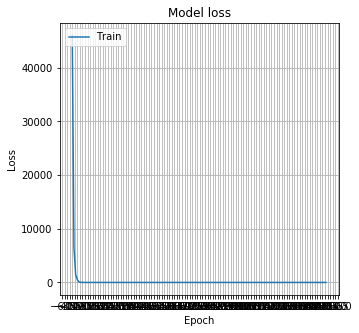

In [6]:
# Plot training & validation loss values
fig, ax = plt.subplots(figsize=(5, 5), sharex=True)
plt.plot(history.history["loss"])
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
ax.xaxis.set_major_locator(plt.MaxNLocator(epochs))
plt.legend(["Train", "Test"], loc="upper left")
plt.grid()
plt.show()

In [7]:
# make a one step prediction out of sample
print(goddard_series[-10:])
serie_input = goddard_series[-20:-10]
print(serie_input)
x_input = serie_input.reshape((1, n_input))
yhat = model.predict(x_input, verbose=0)
print(yhat)

[1360.8125 1361.     1361.0625 1361.0625 1361.125  1360.625  1360.4375
 1360.4062 1360.3906 1360.375 ]
[1361.125  1361.5    1361.3125 1361.0625 1360.8125 1360.6875 1360.625
 1360.4375 1360.375  1360.625 ]
[[1360.0121]]


In [8]:
list1 = yhat[0].tolist()
answer = str(round(list1[0], 2))
a_list = np.append(goddard_series[-9:], answer)
x_input = a_list.reshape((1, n_input))
yhat = model.predict(x_input, verbose=0)
list1 = yhat[0].tolist()

In [9]:
for i in range(9):
    list1 = yhat[0].tolist()
    answer = str(round(list1[0], 2))
    a_list = np.append(a_list[-9:], answer)
    x_input = a_list.reshape((1, n_input))
    yhat = model.predict(x_input, verbose=0)
    list1 = yhat[0].tolist()

In [10]:
s_prediction = []
a1 = goddard_series[-int(size_forecast+1)]
for i in range(int(size_forecast)):
    bond = float(a_list[i])
    s_prediction.append(bond)
s_prediction.insert(0, goddard_series[-int(size_forecast+1)])

In [11]:
beta = s_prediction
alpha = goddard_series[-11:].tolist()

In [12]:
print(alpha)
print(len(alpha))
print(beta)
print(len(beta))

[1360.625, 1360.8125, 1361.0, 1361.0625, 1361.0625, 1361.125, 1360.625, 1360.4375, 1360.4062, 1360.3906, 1360.375]
11
[1360.625, 1360.01, 1359.74, 1359.57, 1359.41, 1359.3, 1359.13, 1358.94, 1358.77, 1358.59, 1358.44]
11


11
101


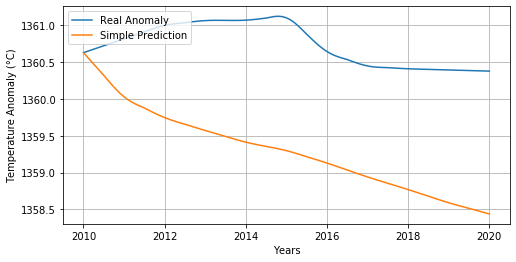

In [13]:
prediction_resampled = resample_1(beta)
real_anomaly_resampled = resample_1(alpha)
fig, ax = plt.subplots(figsize=(8,4))
e=list(range(len(prediction_resampled)))
e = [x/10 for x in e]
e = [x + (2010) for x in e]
ax.plot(e, real_anomaly_resampled)
ax.plot(e, prediction_resampled)
ax.set_xlabel('Years')
ax.set_ylabel('Temperature Anomaly (°C)');
ax.legend(['Real Anomaly','Simple Prediction'], loc='upper left')
ax.grid()
print(len(beta))
print(len(prediction_resampled))

In [14]:
#np.savetxt('anomaly_predicted_dense.csv',prediction_resampled, delimiter=',', header=str('temperature'), comments="")